In [1]:
import re
import os
import sys
import time
import random
import string
import pathlib
import logging
from collections import Counter

import numpy as np
import pandas as pd
import polars as pl 

import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from konlpy.tag import Okt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import tensorflow_text as text
import tensorflow_datasets as tfds

from sklearn.preprocessing import LabelEncoder

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Attention 구현

* Attention - transformer에서 사용하는 3가지 어텐션
    1. Encoder Self-Attention: 인코더에서 이루어지는 어텐션 (Query = Key = Value)
    2. Masked Decoder Self-Attention: 디코더 (Query = Key = Value)
    3. Encoder-Decoder Attention: 디코더 (Query: Decoder Vector / Key = Value: Encoder Vector)

|||
|--|--|
|<img src="./in_image/8.gif">|<img src="./in_image/7.png">|

## Positional Encoding

* 어텐션 레이어는 입력을 순차적인 순서가 없는 벡터 세트로 봅니다.
* 이 모델에는 순환 또는 컨볼루션 레이어도 포함되어 있지 않습니다.
* 이 때문에 "위치 인코딩"이 추가되어 모델에 문장에서 토큰의 상대적 위치에 대한 정보를 제공합니다.

* 위치 인코딩 벡터가 임베딩 벡터에 추가됩니다.
* 임베딩은 비슷한 의미를 가진 토큰이 서로 더 가까워지는 d차원 공간의 토큰을 나타냅니다.
* 그러나 임베딩은 문장에서 토큰의 상대적 위치를 인코딩하지 않습니다.
* 따라서 위치 인코딩을 추가한 후 토큰은 d차원 공간 에서 의미의 유사성과 문장에서의 위치에 따라 서로 더 가까워집니다.

* 위치 인코딩을 계산하는 공식은 다음과 같습니다.

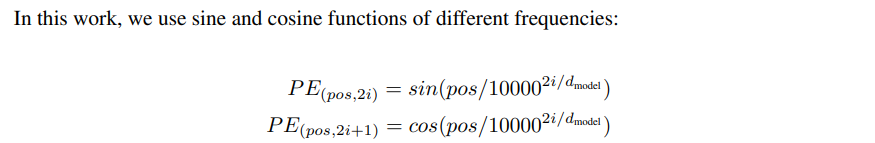

In [4]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2*(i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        angles_rads = self.get_angles(position = tf.range(position, dtype=tf.float32)[:, tf.newaxis], # 500
                                     i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], # 512
                                     d_model = d_model)
        #angles_rads.shape = (position,d_model)
        
        # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
        sines = tf.math.sin(angles_rads[:, 0::2])
        
        # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
        cosines = tf.math.cos(angles_rads[:, 1::2])
        
        angles_rads = np.zeros(angles_rads.shape)
        angles_rads[:, 0::2] = sines
        angles_rads[:, 1::2] = cosines
        pos_encoding = tf.constant(angles_rads)

        pos_encoding = pos_encoding[tf.newaxis, ...] # tensor에 하나의 차원이 추가됨 (1,500,512)
        
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

(1, 2048, 512)


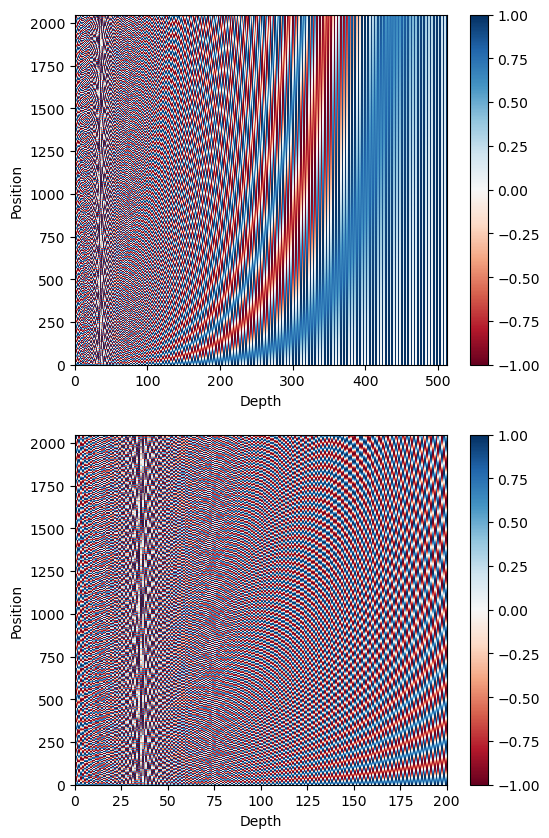

In [5]:
sample_pos_encoding = PositionalEncoding(2048, 512)
print(sample_pos_encoding.pos_encoding.shape)
plt.figure(figsize=(6,10))

plt.subplot(2,1,1)
plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()

plt.subplot(2,1,2)
plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 200))
plt.ylabel('Position')
plt.colorbar()

plt.show()

## Scaled dot product Attention

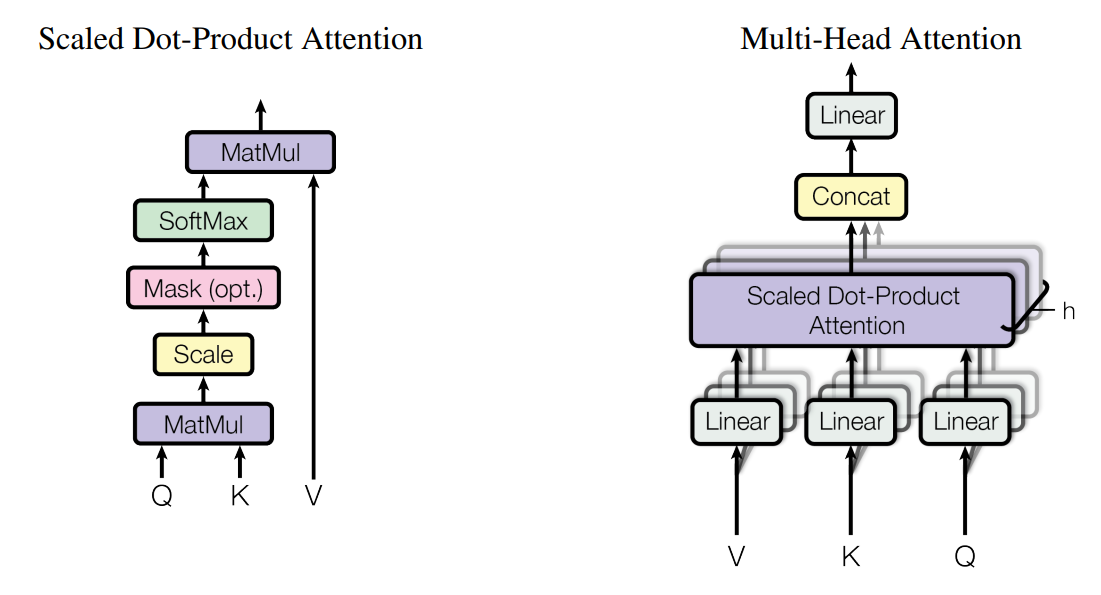

In [6]:
def scaled_dot_product_attention(query, key, value, mask):
    # query 크기: (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # key y크기: (batct_size, num_heads, key의 문장 길이, d_model/num_heads)
    # value 크기: (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    # padding_mask: (batch_size, 1, 1, key의 문장 길이)
    
    # Q와 K의 곱. Attention score 행렬,
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    
    # scaling
    # dk의 루트 값으로 나눔
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    scaled_attention_logits  = matmul_qk / tf.math.sqrt(depth)
    
    # 마스킹. Attention score matrix의 마스킹 할 위치에 매우 작은 음수값을 넣음
    # 매우 작은 값이므로 softmax 함수를 지나면 행렬의 해당 위치 값은 0이 됨
    if mask is not None:
        scaled_attention_logits  += (mask * -1e9)
        
    # softmax 함수는 마지막 차원인 key의 문장 길이 방향으로 수행됨
    # attention weight: (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    
    # output: (batch_size, num_heads, query의 문장 길이, d_model / num_heads)
    output = tf.matmul(attention_weights, value)
    
    return output, attention_weights

In [7]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
    print('Attention weights are:')
    print(temp_attn)
    print('Output is:')
    print(temp_out)

np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)
print()
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)
print()
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi head Attention

<img src="./in_image/1.png" width="100%" height="300">
<img src="./in_image/2.png" width="30%" height="30">

1. $W^Q, W^K, W^V$의 크기의 밀집층(Dense layer)을 지나게 함
2. 지정된 헤드 수(num_heads)만큼 나눔(split)
3. scaled-dot product attention
4. 나눠진 헤드들을 concatenatetion
5. $W^0$에 해당하는 밀집층을 지나게 함
6. 최종 Multi head attention의 결과물

In [8]:
from tensorflow.keras.layers import Dense, Layer

class MultiHeadAttention(Layer):
    
    def __init__(self, d_model, num_heads, name='multi_head_attention'):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        # d_model을 num_heads 로 나눈 값.
        # 논문 기준: 64
        self.depth = d_model // self.num_heads
        
        # WQ, WK, WV에 해당하는 밀집층 정의
        self.query_dense = Dense(d_model)
        self.key_dense = Dense(d_model)
        self.value_dense = Dense(d_model)
        
        # W0에 해당하는 밀집층 정의
        self.dense = Dense(d_model)
        
    
    # num_heads 개수만큼 q, k, v를 split 하는 함수
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3]) # batch, num_heads, seq_len, depth
    
    def call(self, value, key, query, mask):
        batch_size = tf.shape(query)[0]
        
        # 1. WQ, WK, WV에 해당하는 밀집층 지나기
        # q: (batch_size, query의 문장 길이, d_model)
        # k: (batch_size, key의 문장 길이, d_model)
        # v: (batch_size, value의 문장 길이, d_model)
        # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있음
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        # 2. 헤드 나누기
        # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
        # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        # 3. scaled-dot product attention
        # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        scaled_attention, attention_weights = scaled_dot_product_attention(query, key, value, mask)
        # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # 4. 헤드 연결(concatenate) 하기
        # (batch_size, query의 문장 길이, d_model)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        
        # 5. W0에 해당하는 밀집층 지나기
        # (batch_size, query의 문장 길이, d_model)
        outputs = self.dense(concat_attention)
        
        return outputs, attention_weights

In [9]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(value=y, key=y, query=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Padding Mask

* 시퀀스 배치에서 모든 패드 토큰을 마스킹합니다.
* 모델이 패딩을 입력으로 취급하지 않도록 합니다.
* 마스크는 패드 값 0 이 있는 위치를 나타냅니다.
* 해당 위치에서 1 을 출력하고 그렇지 않으면 0 을 출력합니다.

In [10]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # ( batch_size, 1, 1, key의 문장 길이(seq_len) )
    return mask[:, tf.newaxis, tf.newaxis, :]

print(create_padding_mask(tf.constant([[1, 21, 777, 0, 0]])))

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


## Position-wise FFNN(Feed-Forward Neural Network)

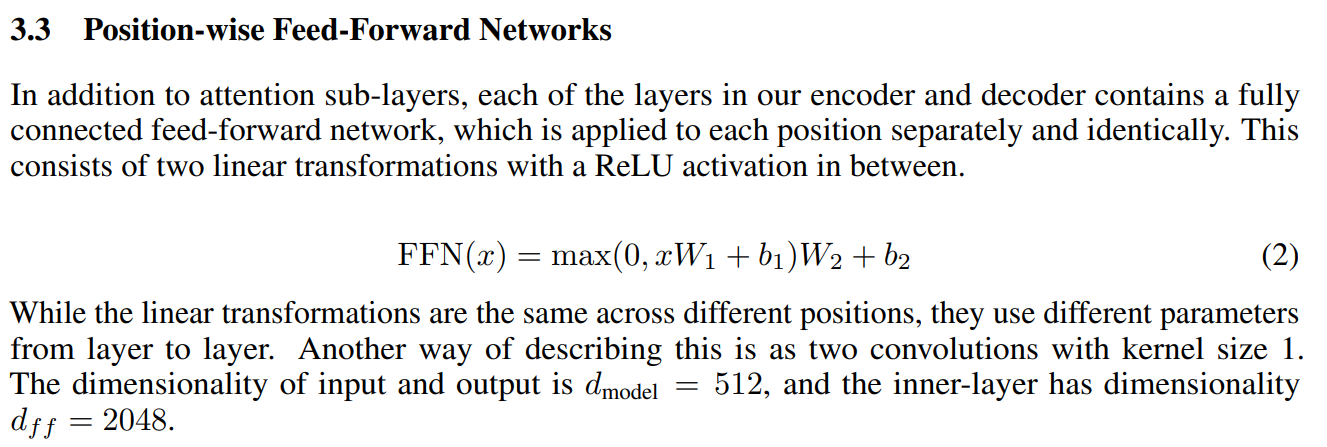

*  Dense -> ReLU -> Dense

In [11]:
from tensorflow.keras.layers import Dense

def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [12]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Residual connections + (Layer Normalization & Dropout)

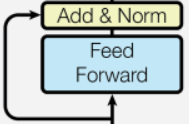

* Layer Normalization 
    1. 평균, 분산 정규화 ($x \rightarrow \hat{x}$)
    2. ${ln}_i = \gamma\hat{x}+\beta = LayerNorm(x)$    :      ($\hat{x}_{i,k} = \frac{x_{i,k}-\mu_i}{\sqrt{\sigma^2_i + \epsilon}}$)

In [13]:
from tensorflow.keras.layers import Dropout, LayerNormalization

# # Dropout + Add & Norm
# outputs = Dropout(rate=dropout)(outputs)
# outputs = LayerNormalization(epsilon=1e-6)(attention + outputs)

# Encoder 구현

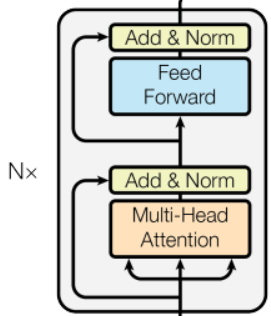

In [14]:
class EncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        # Multi head attention 통과
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        # Residual connections + (Layer Normalization & Dropout)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        
        # Fead Forward
        # Residual connections + (Layer Normalization & Dropout)
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [15]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

# sample  생성
sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), # x
    False, # training
    None # mask
)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [16]:
from tensorflow.keras.layers import Embedding, Dropout

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers,# encoder layer 개수
                 d_model, # 512
                 num_heads, # 8
                 dff, # 2048
                 input_vocab_size, # 단어사전 크기
                 maximum_position_encoding, # PE 최대 크기
                 rate=0.1 # Dropout rate
                ):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = Embedding(input_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(maximum_position_encoding,
                                                self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]

        self.dropout = Dropout(rate)

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = self.pos_encoding(x)

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [17]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


# Decoder 구현

|구분|이미지|
|:--:|:--:|
|전체|!<img src="in_image/3.png" width="50%">|
|첫번째 sublayer|<img src="in_image/4.png" width="50%">|
|두번째 sublayer|<img src="in_image/6.png" width="50%">|

* Attention 의 종류

<img src="in_image/5.png" width="50%">

## Look ahead mask (+Padding mask)

In [18]:
# 디코더의 첫번째 서브층에서 미래 토큰을 mask 하는 함수 + Padding mask 적용
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x) # 패딩마스크도 포함
    
    return tf.maximum(look_ahead_mask, padding_mask)

In [19]:
# 1 이 비활성화
create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5, 7, 9, 0, 0, 0, 0, 0]]))

<tf.Tensor: shape=(1, 1, 12, 12), dtype=float32, numpy=
array([[[[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]]]],
      dtype=float32)>

## Decoder layer

In [20]:
class DecoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        # 첫번째 서브층의 MHA
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        # 두번째 서브층의 MHA
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        # Feed Forward 층
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

        # 디코더의 첫번째 서브층은 Mask + Self attention
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        # 디코더 두번째 서브층은 Encoder - Decoder Attention + Padding mask
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output,
                                               out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        
        # Dropout, LN, 잔차연결
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        # Feed Forward Network
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        # Dropout, LN, 잔차연결
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [21]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), # x
    sample_encoder_layer_output, # encoder_output
    False, # training
    None, # look ahead mask
    None # padding mask
)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

## Decoder

In [22]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self,
                 num_layers,
                 d_model,
                 num_heads,
                 dff,
                 target_vocab_size,
                 maximum_position_encoding,
                 rate=0.1
                ):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = Embedding(target_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = self.pos_encoding(x)

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [23]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

# Transformer 구현

<img src="in_image/7.png" width="30%" height="30">

In [24]:
from tensorflow.keras import Model

class Transformer(tf.keras.Model):
    def __init__(self,
                 num_layers,
                 d_model,
                 num_heads,
                 dff,
                 input_vocab_size,
                 target_vocab_size,
                 pe_input,
                 pe_target,
                 rate=0.1
                ):
        
        super().__init__()
        # Encoder
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                                 input_vocab_size, pe_input, rate)
        # Decoder
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, pe_target, rate)
        # Linear (Softmax 는 생략)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs, training):
        # model input 받기 (source, target)
        inp, tar = inputs

        enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

    def create_masks(self, inp, tar):
        # 3개의 mask 제작
        
        # 1. Encoder 의 padding mask
        enc_padding_mask = create_padding_mask(inp)

        # 2. Decoder 두번째 sub층의 padding mask
        dec_padding_mask = create_padding_mask(inp)

        # 3. Decoder 첫번째 sub층의 look ahead mask
        # look ahead mask 와 padding mask를 합침
        look_ahead_mask = create_look_ahead_mask(tar)

        return enc_padding_mask, look_ahead_mask, dec_padding_mask

In [46]:
transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = transformer([temp_input, temp_target], training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

In [47]:
transformer.summary()

Model: "transformer_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_4 (Encoder)         multiple                  10656768  
                                                                 
 decoder_4 (Decoder)         multiple                  12504064  
                                                                 
 dense_217 (Dense)           multiple                  4104000   
                                                                 
Total params: 27,264,832
Trainable params: 27,264,832
Non-trainable params: 0
_________________________________________________________________


# Loss & Optimizer

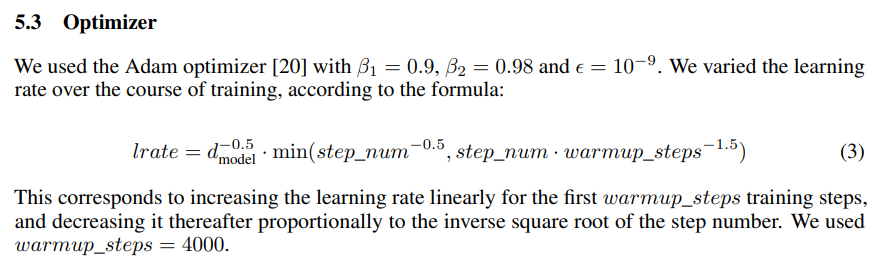

In [30]:
def loss_function(y_true, y_pred):
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    loss_ = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

def accuracy_function(y_true, y_pred):
    accuracies = tf.equal(y_true, tf.argmax(y_pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

Text(0.5, 0, 'Train Step')

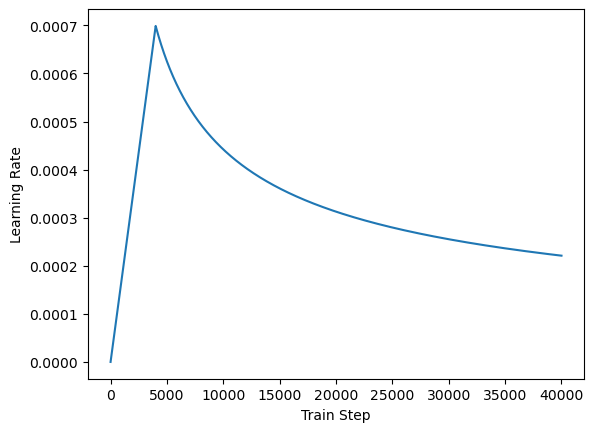

In [31]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomSchedule(d_model=512)

plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [32]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
valid_loss = tf.keras.metrics.Mean(name='train_loss')
valid_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

learning_rate = CustomSchedule(d_model=512)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

# Training

## Sample data prepare

### 데이터 다운

In [33]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

In [34]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
    for pt in pt_examples.numpy():
        print(pt.decode('utf-8'))

    print()

    for en in en_examples.numpy():
        print(en.decode('utf-8'))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


### Tokenizer

In [35]:
model_name = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(
    f"{model_name}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
    cache_dir='.', cache_subdir='', extract=True
)

'.\\ted_hrlr_translate_pt_en_converter.zip'

In [36]:
tokenizers = tf.saved_model.load(model_name)

In [ ]:
for en in en_examples.numpy():
    print(en.decode('utf-8'))

In [ ]:
# enlish 토큰화 샘플
encoded = tokenizers.en.tokenize(en_examples)

for row in encoded.to_list():
    print(row)

In [37]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return pt, en

In [38]:
BUFFER_SIZE = 20000
BATCH_SIZE = 32

def make_batches(ds):
    return (
        ds
        .cache()
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
        .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [39]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [40]:
tokenizers.pt.get_vocab_size(), tokenizers.en.get_vocab_size()

(<tf.Tensor: shape=(), dtype=int32, numpy=7765>,
 <tf.Tensor: shape=(), dtype=int32, numpy=7010>)

In [48]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [49]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

In [50]:
# @tf.function 에서 graph calculation 을 적용할 input 인자 설정 ( output 도 설정 가능 )
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

# tf.function은 그래프를 미리 컴파일 하기 때문에 속도가 상당히 빠름
@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1] # EOS 제외
    tar_real = tar[:, 1:] # SOS 제외

    with tf.GradientTape() as tape:
        predictions, _ = transformer([inp, tar_inp],
                                     training = True)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))
    
@tf.function(input_signature=train_step_signature)
def valid_step(inp, tar):
    tar_inp = tar[:, :-1] # EOS 제외
    tar_real = tar[:, 1:] # SOS 제외

    with tf.GradientTape() as tape:
        predictions, _ = transformer([inp, tar_inp],
                                     training = False)
        loss = loss_function(tar_real, predictions)

    valid_loss(loss)
    valid_accuracy(accuracy_function(tar_real, predictions))

In [51]:
EPOCHS = 20

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()
    valid_loss.reset_states()
    valid_accuracy.reset_states()
    print("-"*66)
    # 여기서 input 은 포르투갈어, output은 영어
    for (batch, (inp, tar)) in enumerate(train_batches):
        train_step(inp, tar)
        if batch % 100 == 0:
            print(f'Epoch {epoch + 1: 03d} | Batch {batch:04d} | Train Loss {train_loss.result():.4f} | Train Accuracy {train_accuracy.result():.4f}')

    for (inp, tar) in val_batches:
        valid_step(inp, tar)
        
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

    print(f'Epoch {epoch + 1: 03d} | Train Loss {train_loss.result():.4f} | Train Accuracy {train_accuracy.result():.4f}')
    print(f'Epoch {epoch + 1: 03d} | Valid Loss {valid_loss.result():.4f} | Valid Accuracy {valid_accuracy.result():.4f}')

    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

------------------------------------------------------------------
Epoch  01 | Batch 0000 | Train Loss 8.8866 | Train Accuracy 0.0000
Epoch  01 | Batch 0100 | Train Loss 6.9163 | Train Accuracy 0.0486
Epoch  01 | Batch 0200 | Train Loss 6.5120 | Train Accuracy 0.0801
Epoch  01 | Batch 0300 | Train Loss 6.2729 | Train Accuracy 0.1037
Epoch  01 | Batch 0400 | Train Loss 6.0867 | Train Accuracy 0.1241
Epoch  01 | Batch 0500 | Train Loss 5.9457 | Train Accuracy 0.1382
Epoch  01 | Batch 0600 | Train Loss 5.8247 | Train Accuracy 0.1498
Epoch  01 | Batch 0700 | Train Loss 5.7361 | Train Accuracy 0.1586
Epoch  01 | Batch 0800 | Train Loss 5.6556 | Train Accuracy 0.1667
Epoch  01 | Batch 0900 | Train Loss 5.5906 | Train Accuracy 0.1735
Epoch  01 | Batch 1000 | Train Loss 5.5332 | Train Accuracy 0.1794
Epoch  01 | Batch 1100 | Train Loss 5.4783 | Train Accuracy 0.1849
Epoch  01 | Batch 1200 | Train Loss 5.4336 | Train Accuracy 0.1896
Epoch  01 | Batch 1300 | Train Loss 5.3905 | Train Accuracy 0.

Epoch  07 | Batch 0000 | Train Loss 3.0657 | Train Accuracy 0.4766
Epoch  07 | Batch 0100 | Train Loss 3.2818 | Train Accuracy 0.4332
Epoch  07 | Batch 0200 | Train Loss 3.2915 | Train Accuracy 0.4312
Epoch  07 | Batch 0300 | Train Loss 3.2924 | Train Accuracy 0.4313
Epoch  07 | Batch 0400 | Train Loss 3.2868 | Train Accuracy 0.4329
Epoch  07 | Batch 0500 | Train Loss 3.2729 | Train Accuracy 0.4351
Epoch  07 | Batch 0600 | Train Loss 3.2681 | Train Accuracy 0.4367
Epoch  07 | Batch 0700 | Train Loss 3.2654 | Train Accuracy 0.4371
Epoch  07 | Batch 0800 | Train Loss 3.2654 | Train Accuracy 0.4372
Epoch  07 | Batch 0900 | Train Loss 3.2621 | Train Accuracy 0.4376
Epoch  07 | Batch 1000 | Train Loss 3.2557 | Train Accuracy 0.4386
Epoch  07 | Batch 1100 | Train Loss 3.2541 | Train Accuracy 0.4390
Epoch  07 | Batch 1200 | Train Loss 3.2458 | Train Accuracy 0.4404
Epoch  07 | Batch 1300 | Train Loss 3.2437 | Train Accuracy 0.4406
Epoch  07 | Batch 1400 | Train Loss 3.2423 | Train Accuracy 0.

Epoch  13 | Batch 0100 | Train Loss 2.4318 | Train Accuracy 0.5497
Epoch  13 | Batch 0200 | Train Loss 2.4505 | Train Accuracy 0.5477
Epoch  13 | Batch 0300 | Train Loss 2.4647 | Train Accuracy 0.5453
Epoch  13 | Batch 0400 | Train Loss 2.4591 | Train Accuracy 0.5465
Epoch  13 | Batch 0500 | Train Loss 2.4673 | Train Accuracy 0.5451
Epoch  13 | Batch 0600 | Train Loss 2.4666 | Train Accuracy 0.5453
Epoch  13 | Batch 0700 | Train Loss 2.4663 | Train Accuracy 0.5451
Epoch  13 | Batch 0800 | Train Loss 2.4660 | Train Accuracy 0.5452
Epoch  13 | Batch 0900 | Train Loss 2.4649 | Train Accuracy 0.5455
Epoch  13 | Batch 1000 | Train Loss 2.4629 | Train Accuracy 0.5458
Epoch  13 | Batch 1100 | Train Loss 2.4629 | Train Accuracy 0.5458
Epoch  13 | Batch 1200 | Train Loss 2.4623 | Train Accuracy 0.5458
Epoch  13 | Batch 1300 | Train Loss 2.4634 | Train Accuracy 0.5458
Epoch  13 | Batch 1400 | Train Loss 2.4628 | Train Accuracy 0.5460
Epoch  13 | Batch 1500 | Train Loss 2.4629 | Train Accuracy 0.

Epoch  19 | Batch 0200 | Train Loss 2.0608 | Train Accuracy 0.6027
Epoch  19 | Batch 0300 | Train Loss 2.0687 | Train Accuracy 0.6013
Epoch  19 | Batch 0400 | Train Loss 2.0706 | Train Accuracy 0.6014
Epoch  19 | Batch 0500 | Train Loss 2.0716 | Train Accuracy 0.6013
Epoch  19 | Batch 0600 | Train Loss 2.0806 | Train Accuracy 0.6001
Epoch  19 | Batch 0700 | Train Loss 2.0846 | Train Accuracy 0.5997
Epoch  19 | Batch 0800 | Train Loss 2.0803 | Train Accuracy 0.6003
Epoch  19 | Batch 0900 | Train Loss 2.0816 | Train Accuracy 0.6000
Epoch  19 | Batch 1000 | Train Loss 2.0825 | Train Accuracy 0.6002
Epoch  19 | Batch 1100 | Train Loss 2.0812 | Train Accuracy 0.6004
Epoch  19 | Batch 1200 | Train Loss 2.0833 | Train Accuracy 0.6001
Epoch  19 | Batch 1300 | Train Loss 2.0864 | Train Accuracy 0.5997
Epoch  19 | Batch 1400 | Train Loss 2.0863 | Train Accuracy 0.5998
Epoch  19 | Batch 1500 | Train Loss 2.0903 | Train Accuracy 0.5994
Epoch  19 | Batch 1600 | Train Loss 2.0919 | Train Accuracy 0.

# 추론

* 추론과정은 훈련과정과 다르게 진행됩니다.
* 번역할 언어가 encoder를 거치고 decoder에는 영어문장의 <SOS> 토큰만 들어가게 됩니다.
* 이렇게 들어가 다음 단어를 예측하고 누적합합니다.
* 계속해서 예측된 단어들 모두를 가지고 다음 단어를 예측하는데 활용합니다.

## tfds의 양식에 맞는 Translotor

In [62]:
class Translator(tf.Module):

    def __init__(self, tokenizers, transformer):
        self.tokenizers = tokenizers # 토크나이저
        self.transformer = transformer # 네트워크

    def __call__(self, sentence, max_length=20):
        
        # 최대 길이 20에 도달하거나 <EOS>를 출력하면 멈춤
        assert isinstance(sentence, tf.Tensor)
        if len(sentence.shape) == 0:
            sentence = sentence[tf.newaxis]

        sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

        encoder_input = sentence

        # as the target is english, the first token to the transformer should be the
        # english start token.
        start_end = self.tokenizers.en.tokenize([''])[0]
        start = start_end[0][tf.newaxis]
        end = start_end[1][tf.newaxis]

        # `tf.TensorArray` is required here (instead of a python list) so that the
        # dynamic-loop can be traced by `tf.function`.
        output_array = tf.TensorArray(dtype=tf.int64,
                                      size=0,
                                      dynamic_size=True)
        output_array = output_array.write(0, start)

        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
            predictions, _ = self.transformer([encoder_input, output],
                                              training=False)

            # select the last token from the seq_len dimension
            predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

            predicted_id = tf.argmax(predictions, axis=-1)

            # concatentate the predicted_id to the output which is given to the decoder
            # as its input.
            output_array = output_array.write(i + 1, predicted_id[0])

            if predicted_id == end:
                break

        output = tf.transpose(output_array.stack())
        # output.shape (1, tokens)
        text = tokenizers.en.detokenize(output)[0]  # shape: ()

        tokens = tokenizers.en.lookup(output)[0]

        # `tf.function` prevents us from using the attention_weights that were
        # calculated on the last iteration of the loop. So recalculate them outside
        # the loop.
        _, attention_weights = self.transformer(
            [encoder_input, output[:, :-1]], training=False)

        return text, tokens, attention_weights

In [66]:
translator = Translator(tokenizers, transformer)

def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')
    return tokens.numpy(), ground_truth

In [67]:
sentence = "este é um problema que temos que resolver."
ground_truth = "this is a problem we have to solve ."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
y_pred, y_true = print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


In [84]:
import nltk.translate.bleu_score as bleu
print([y_pred.decode("utf-8").split()])
print(y_true.split())
bleu.sentence_bleu( [y_pred.decode("utf-8").split()], y_true.split() )

[['this', 'is', 'a', 'problem', 'that', 'we', 'have', 'to', 'solve', '.']]
['this', 'is', 'a', 'problem', 'we', 'have', 'to', 'solve', '.']


0.6690484408935986

## 일반적인 Translator

In [59]:
def evaluate(inp_sentence):
    # inp_sentence : 문자 (string)
    start_token = [tokenizers.pt.vocab_size]  # 포르투갈어의 시작 토큰
    end_token = [tokenizers.pt.vocab_size + 1]  # 포르투갈어의 끝 토큰

    # 시작 토큰 + 포르투갈 어 + 끝 토큰
    inp_sentence = start_token + tokenizers.pt.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # 디코더의 인풋은 영어 문장의 시작 토큰만 들어감
    decoder_input = [tokenizers.en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_LENGTH):
        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions = transformer(encoder_input, output, False)

        # 예측 결과에서 마지막 부분만 추출
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약에 예측된 영어 단어가 영어의 끝 토큰에 해당한다면 예측을 끝냄
        if predicted_id == tokenizers.en.vocab_size + 1:
            return tf.squeeze(output, axis=0)

        # 예측된 단어를 전 단어와 결합하여 다음 예측에 써먹음
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)

In [60]:
def translate(sentence):
    result= evaluate(sentence)

    predicted_sentence = tokenizers.en.decode([i for i in result 
                                            if i < tokenizers.en.vocab_size])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))

In [85]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")